# 548 22sp exam2 due 11:59p Sat Jun 4

***You are welcome (and encouraged) to:***
- use analytical and numerical computational tools -- specify the tool(s) in sourcecode and/or text;
- reuse example sourcecode and other materials provided in this course;
- consult textbooks, websites, and other publicly-available materials -- include full citation(s) with the URL and/or [DOI](https://en.wikipedia.org/wiki/Digital_object_identifier).

***You are not permitted to discuss the exam problems or share any part of your solutions with anyone other than the instructional staff (Professor and/or TA[s]) for this course.***
- By submitting your exam solution on Canvas, you are affirming your understanding of and adherence to these restrictions.
- We will answer questions during the class Zoom meetings Tue and Thu of the exam week.
- We will also answer questions posted to the Canvas Discussion board until 5p Fri of the exam week.

***The exam deadline is midnight (11:59p) Saturday on Canvas.***
- Final submissions received before this deadline will receive +2 bonus points (equal to one subproblem).
- Everyone automatically receives a deadline extension to midnight (11:59p) Sunday. ***No further deadline extensions will be granted except in exceptional circumstances -- please plan accordingly, but do reach out if you need help.***

In [14]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      # pdb.set_trace()
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# design problem

***The entire exam will be devoted to the following design problem, with the goal of providing an opportunity to apply all of the key techniques we learned this quarter to a single system.***

Consider the simplified vertical-plane quadrotor model
$$ M\ddot{\eta} = F\sin\theta, $$
$$ M\ddot{\nu} = -Mg + F\cos\theta, $$
$$ I\ddot{\theta} = \tau $$
where ($\eta$, $\nu$) denote the quadrotor (horizontal, vertical) position and $\theta$ denotes the quadrotor's rotation, ($M$, $I$) denote quadrotor (mass, inertia), $g$ is acceleration due to gravity, and ($F$, $\tau$) denote the net (thrust, torque) applied by the spinning rotors.

With $q = (\eta,\nu,\theta)\in\mathbb{R}^3$ denoting positions and $\dot{q} = \frac{d\ }{dt} q = (\dot{\eta},\dot{\nu},\dot{\theta})\in\mathbb{R}^3$ denoting velocities,
the state vector is $x = (q,\dot{q})\in\mathbb{R}^6$,
and
the input vector is $u = (F,\tau)\in\mathbb{R}^2$.

If we measure or observe positions ($\eta$, $\nu$), e.g. with GPS, then the nonlinear (NL) control system model is
$$ \text{(NL)}\quad \dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ \ddot{q}(x,u) \end{array}\right] = f(x,u),\ y = h(x) $$
where $\ddot{q} : \mathbb{R}^6 \times \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is defined by 
$$\ddot{q}(x,u) = \left[\begin{array}{c} \frac{F}{M}\sin\theta \\ -g + \frac{F}{M}\cos\theta \\ \frac{\tau}{I}\end{array}\right],$$ 
and $h : \mathbb{R}^6 \rightarrow \mathbb{R}^2$ is defined by 
$$h(x) = (\eta,\nu).$$

Use the following parameter values for numerical simulations:  $M = 1\,\text{kg}$, $I = 0.01\,\text{kg}\,\text{m}^2$, $g = 9.81\,\text{m}\,\text{sec}^{-2}$.

For more details about this model and a schematic diagram, refer to [this paper](http://dx.doi.org/10.1109/ROBOT.2010.5509452).

# part 1:  discrete-time, finite-horizon

## subproblem (a)

Discretize the nonlinear system:  choose a step size $\Delta > 0$ and time horizon $T \gg \Delta$ so that the *forward Euler* approximation $x(t + \Delta) \approx x(t) + \Delta\, f(x(t),u(t))$ yields reasonably good approximation of trajectories on the time interval $t\in [0,T]$.  Provide plots that show the approximation is reasonable by simulating the nonlinear system twice -- once with your chosen step size $\Delta$, and once with step size $\nabla \ll \Delta$; the second simulation will be used as the "ground truth".  Use non-constant input signals $F$ and $\tau$ in your simulation.

***Note:*** there is no one right choice for $\Delta$, but it will be helpful in what follows if you choose a large step size.

## solution

We'll simulate the result of applying a sum-of-sinusoids as thrust and torque inputs and use plots and animations to visualize the result:

In [348]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as animation
from IPython.display import HTML
mpl.rc('animation', html='jshtml')
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

In [349]:
M = 1; I = 0.01; g = 9.81

def f(t,x,u,M=M,I=I,g=g):
    q,dq = x[:3],x[3:] # positions, velocities
    eta,nu,theta = q # horiz., vert., rotation
    F,tau = u # thrust, torque
    ddq = [np.sin(theta)*F/M, -g + np.cos(theta)*F/M, tau/I]
    dx = np.hstack([dq,ddq])
    return dx

def h(t,x,u,M=M,I=I,g=g):
    return x[:2]

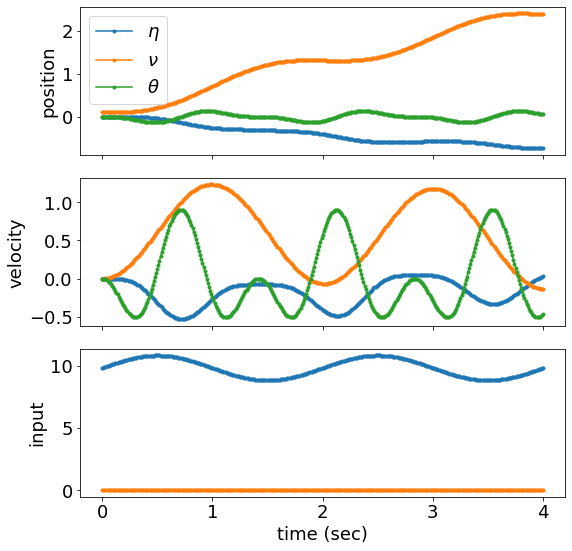

In [350]:
dt = 1e-2 # coarse timestep
freq1 = .5 # one cycle every two seconds
freq2 = np.sqrt(2)*freq1 # incommensurate frequency
T = 2./freq # two periods
q = [0.,.1,0.] # start 10cm up off the ground
dq = [0.,0.,0.] # start with zero velocity
x = np.hstack((q,dq))

# input is a periodic function of time
ut = lambda t,M=M,g=g : np.array([M*g + 2*np.sin(2*np.pi*t*freq1),
                                  2e-2*(np.sin(2*np.pi*t*freq2)-2*np.sin(2*np.pi*t*freq2*2))])

sim = numerical_simulation
t_,x_ = sim(f,T,x,dt=dt,ut=ut)
u_ = np.array([u(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. pos. and vel.) at time t_[j]

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=1,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [351]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# initialization -- called once
def init():
  gndh,gndv = [-10.,10.,10.,-10.],[0.,0.,-5.,-.5]
  ax.fill(gndh,gndv,'gray')
  line.set_data([], [])
  ax.set_xlim(( -1., 1.))
  ax.set_ylim(( -.15, 2.))
  ax.set_xlabel(r'horiz. pos. $\eta$')
  ax.set_ylabel(r'vert. pos. $\nu$')
  #plt.tight_layout()
  return (line,)

# animation -- called iteratively
def animate(t):
  j = (t_ >= t).nonzero()[0][0]
  h,v,th = x_[j,:3]
  w = .25
  x = np.array([-w/2.,w/2.,np.nan,0.,0.])
  y = np.array([0.,0.,np.nan,0.,+w/3.])
  z = (x + 1.j*y)*np.exp(-1.j*th) + (h + 1.j*v)
  line.set_data(z.real, z.imag)
  return (line,)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                      frames=np.arange(0.,t_[-1],.05), interval=50, blit=True)

Now that we have a nice simulation, we'll play around with step sizes:

In [352]:
dt = 1e-1 # coarse timestep
dt_ = 1e-4 # "ground truth" timestep

sim = numerical_simulation
t_,x_ = sim(f,T,x,dt=dt,ut=ut)
t__,x__ = sim(f,T,x,dt=dt_,ut=ut)

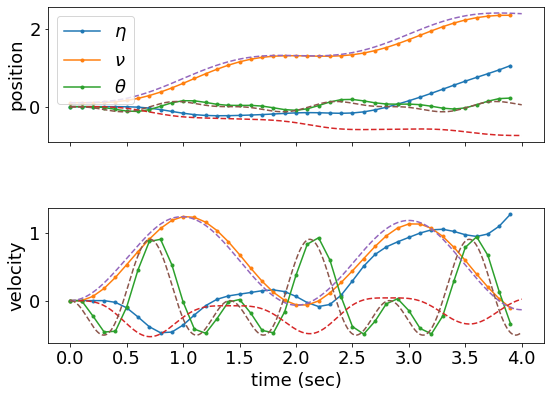

In [353]:
fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.plot(t__,x__[:,:3],'--')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=1,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.plot(t__,x__[:,3:],'--')
ax.set_ylabel('velocity')

ax.set_xlabel('time (sec)')

plt.tight_layout();

The "ground truth" trajectories become visually indistinguishable when $\nabla < 10^{-4}$, so that's what I chose for my "ground truth".  Relative to this, $\Delta = 10^{-1}$ yields reasonable agreement but the 'piecewise-linearity' is readily apparent -- I'll go with that for the remainder of the exam.

## subproblem (b) 

Find an equilibrium $(x_0,u_0)$ for the discretized nonlinear system and linearize the dynamics around this equilibrium to obtain a discrete-time linear time-invariant (DT-LTI) control system model:  determine $A$, $B$, $C$, $D$ such that, with $\delta x = x - x_0$, $\delta u = u - u_0$, and $\delta y = y - y_0$ where $y_0 = h(x_0,u_0)$, we have $x^+ \approx x_0 + \delta x^+$ and $y \approx y_0 + \delta y$ where 

$$ \text{(DT-LTI)}\quad \delta x^+ = A\, \delta x + B\, \delta u,\ \delta y = C\, \delta x + D\, \delta u.$$

## solution

Any value of $\eta_0$ and $\nu_0$ with $\theta_0 = 0$ and $\dot{q}_0 = 0$ yields an equilibrium when $F_0 = M\, g$ and $\tau_0 = 0$ -- we'll choose an operating point one meter above the ground ($\nu_0 = 1$):

In [354]:
q0, dq0 = [0,1,0],[0,0,0]
x0 = np.hstack([q0,dq0])
u0 = np.array([M*g,0])
y0 = h(0,x0,u0)
assert np.allclose(0,f(0,x0,u0))

print('x0 =',x0,'\nf(x0) =',f(0.,x0,u0))

x0 = [0 1 0 0 0 0] 
f(x0) = [0. 0. 0. 0. 0. 0.]


We'll linearize the discretized DE numerically (i.e. take the derivatives of the dynamics and output functions with respect to $x$ and $u$ and evaluate at $x_0$ and $u_0$):

In [355]:
A = Jacobian(lambda x : x + dt*f(0.,x,u0),x)
B = Jacobian(lambda u : x0 + dt*f(0.,x0,u),u0)
C = Jacobian(lambda x : h(0.,x,u0),x)
D = Jacobian(lambda u : h(0.,x,u),u0)

print('A =\n',A)
print('B =\n',B)
print('C =\n',C)
print('D =\n',D)

A =
 [[1.    0.    0.    0.1   0.    0.   ]
 [0.    1.    0.    0.    0.1   0.   ]
 [0.    0.    1.    0.    0.    0.1  ]
 [0.    0.    0.981 1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]
B =
 [[ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.1  0. ]
 [ 0.  10. ]]
C =
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
D =
 [[0. 0.]
 [0. 0.]]


## subproblem (c)

Choose $Q$ and $R$ matrices and solve the finite-horizon LQR problem to synthesize an LTV state-feedback controller for the LTI control system on the time horizon $T$ you chose above.  Run a simulation of the controlled system and provide plots of the state $\delta x$, control $\delta u$, and output $\delta y$ time series.

## solution

An easy choice is to make $Q$ and $R$ scalar multiples of the identity matrix:  $Q = q\, I$, $R = r\, I$, where $q,r > 0$ -- then we can trade off between minimizing state error and control effort by varying the scalar ratio $q/r$.

In [356]:
q = 1.
r = 1.

Q = q*np.eye(x0.size)
R = r*np.eye(u0.size)

Given $A,B,Q,R$ we can precompute the $P$'s and $K$'s at every time on our horizon using the backward-time Riccatti DE.  To simplify the coding task, I'm going to iteratively append to lists containing the $P$'s and $K$'s, and subsequently reverse the list order.

In [357]:
P = [np.zeros((x0.size,x0.size))]
K = [np.zeros((u0.size,x0.size))]
for t in t_:
    P.append( (A - B @ K[-1]).T @ P[-1] @ (A - B @ K[-1]) + K[-1].T @ R @ K[-1] + Q )
    K.append( np.linalg.inv(B.T @ P[-1] @ B + R) @ B.T @ P[-1] @ A )
P = np.asarray(P)[::-1]
K = np.asarray(K)[::-1]

With our $K$'s defined, we can run a simulation of the DT-LTI system with the LQR controller:

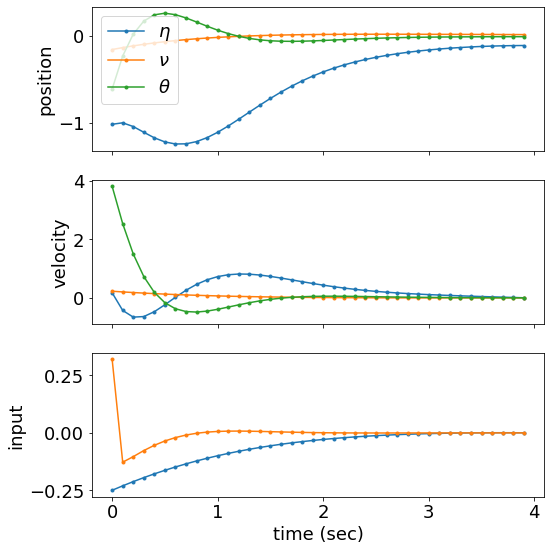

In [358]:
dx = [np.random.randn(x0.size)] # dx in Python == \delta x in LaTeX
du = []
for i,t in enumerate(t_):
    du.append( -K[i] @ dx[-1] )
    dx.append( A @ dx[-1] + B @ du[-1] )
du = np.asarray(du)
dx = np.asarray(dx)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,dx[1:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=1,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,dx[1:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,du,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

## subproblem (d) 

Choose square nonsingular matrices $V_1$ and $V_2$ that multiply standard normal random vectors $w_1\in\mathbb{R}^3$ and $w_2\in\mathbb{R}^2$ to model process and measurement noise,

$$ \delta x^+ = A\, \delta x + B\, \delta u + \left[\begin{array}{c} 0 \\ V_1 \end{array}\right] w_1 ,\ \delta y = C\, \delta x + D\, \delta u + V_2 w_2.$$

Solve the finite-horizon Kalman Filtering problem to synthesize an LTV observer for the LTI control system.  Run a simulation of the LTI system including samples from the process and measurement noise distributions you chose and non-constant input signals, use the resulting data to run a simulation of your LTV Kalman Filter, and provide plots of: the state $\delta x$ and your estimate $\delta\hat{x}$; the noisy output $\delta y$, noise-free output, and observer output $\delta\hat{y}$.

## solution

An easy choice is to make $V_1$ and $V_2$ scalar multiples of the identity matrix:  $V_1 = \sigma_1\, I$, $V_2 = \sigma_2\, I$, where $\sigma_1,\sigma_2 > 0$.  Then the covariances needed for the Kalman iteration are obtained by taking outer products of $V_1$ and $V_2$ with themselves.

In [359]:
# low noise
s1 = 1e-4
s2 = 1e-4

V1 = s1*np.eye(x0.size//2)
V10 = np.vstack((0*V1,V1))
V2 = s2*np.eye(y0.size)

Given $A,C,V_1,V_2$ we can precompute the $M$'s and $L$'s at every time on our horizon using the forward-time Kalman equations. 

In [360]:
M = [np.zeros((x0.size,x0.size))]
L = [np.zeros((x0.size,y0.size))]
I = np.eye(x0.size)
for t in t_:
    W = A @ M[-1] @ A.T + V10 @ V10.T
    M.append( (I - L[-1] @ C) @ W @ (I - L[-1] @ C).T + L[-1] @ V2 @ V2.T @ L[-1].T )
    L.append( W @ C.T @ np.linalg.inv(V2 @ V2.T + C @ W @ C.T) )
M = np.asarray(M)
L = np.asarray(L)

With our $L$'s defined, we can run a simulation of the DT-LTI system with process noise and apply our LTV Kalman filter to the noisy outputs:

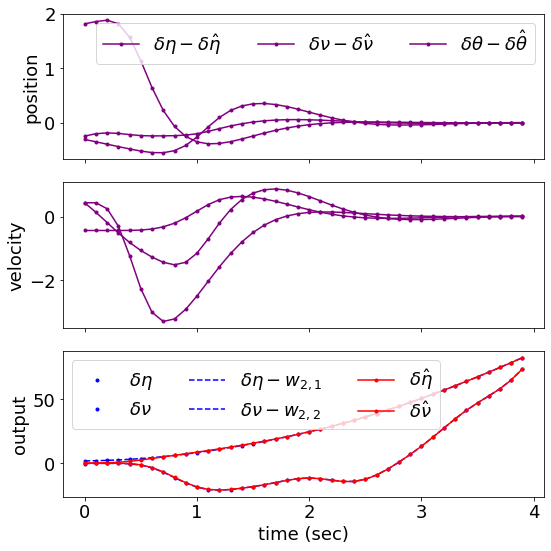

In [361]:
du = []
dx = [np.random.randn(x0.size)] # dx in Python == \delta x in LaTeX
dy = []
dx_ = [np.zeros(x0.size) + 0*np.eye(x0.size)[0]]
for i,t in enumerate(t_):
    # input -- modified sum-of-sinuosoids input from nonlinear system simulation
    du.append( ut(t)*[1,100] ) 
    # noisy process
    w1 = np.random.randn(x0.size//2)
    dx.append( A @ dx[-1] + B @ du[-1] + V10 @ w1 )
    # noisy measurements
    w2 = np.random.randn(y0.size)
    dy.append( C @ dx[-1] + D @ du[-1] + V2 @ w2 )
    # Kalman filter
    X = A @ dx_[-1] + B @ du[-1]
    dx_.append( X + L[i] @ (dy[-1] - C @ X) )
    
du = np.asarray(du)
dx = np.asarray(dx)
dy = np.asarray(dy)
dx_ = np.asarray(dx_)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,(dx-dx_)[1:,:3],'.-',color='purple')
ax.legend([r'$\delta\eta-\delta\hat\eta$',
           r'$\delta\nu-\delta\hat\nu$',
           r'$\delta\theta-\delta\hat\theta$'],ncol=3)
ax.set_xticklabels([])
ax.set_ylabel('position')

ax = plt.subplot(312)
ax.plot(t_,(dx-dx_)[1:,3:],'.-',color='purple')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,dy,'b.')
ax.plot(t_,dx[1:] @ C.T + du @ D.T,'b--')
ax.plot(t_,dx_[1:] @ C.T + du @ D.T,'r.-')
ax.legend([r'$\delta \eta$',r'$\delta \nu$',
           r'$\delta \eta - w_{2,1}$',r'$\delta \nu - w_{2,2}$',
           r'$\delta\hat \eta$',r'$\delta\hat \nu$'],ncol=3)
ax.set_xlabel('time (sec)')
ax.set_ylabel('output')

plt.tight_layout();

This was a ***very*** low-noise simulation, as evidenced by the fact that the state evolves very smoothly and all the signals in the output plot overlap.  

Let's try a higher-noise simulation:

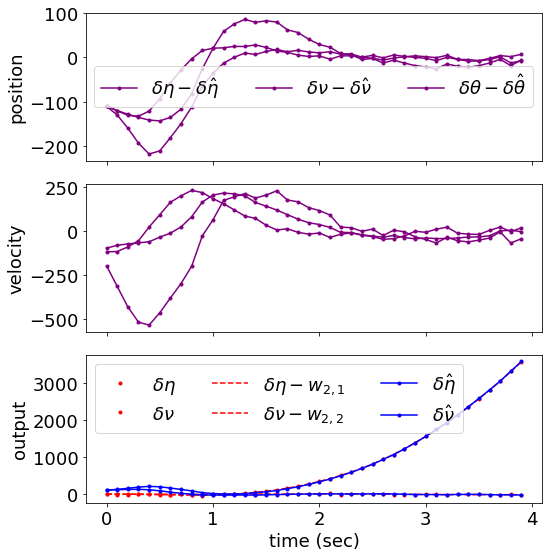

In [362]:
# high noise
s1 = 1e+1
s2 = 1e+1

V1 = s1*np.eye(x0.size//2)
V10 = np.vstack((0*V1,V1))
V2 = s2*np.eye(y0.size)

M = [np.zeros((x0.size,x0.size))]
L = [np.zeros((x0.size,y0.size))]
I = np.eye(x0.size)
for t in t_:
    W = A @ M[-1] @ A.T + V10 @ V10.T
    M.append( (I - L[-1] @ C) @ W @ (I - L[-1] @ C).T + L[-1] @ V2 @ V2.T @ L[-1].T )
    L.append( W @ C.T @ np.linalg.inv(V2 @ V2.T + C @ W @ C.T) )
M = np.asarray(M)
L = np.asarray(L)

du = []
dx = [np.random.randn(x0.size)] # dx in Python == \delta x in LaTeX
dy = []
dx_ = [np.zeros(x0.size) + 100*np.eye(x0.size)@np.ones(x0.size)]
for i,t in enumerate(t_):
    # input -- modified sum-of-sinuosoids input from nonlinear system simulation
    du.append( ut(t)*[1,100] ) 
    # noisy process
    w1 = np.random.randn(x0.size//2)
    dx.append( A @ dx[-1] + B @ du[-1] + V10 @ w1 )
    # noisy measurements
    w2 = np.random.randn(y0.size)
    dy.append( C @ dx[-1] + D @ du[-1] + V2 @ w2 )
    # Kalman filter
    X = A @ dx_[-1] + B @ du[-1]
    dx_.append( X + L[i] @ (dy[-1] - C @ X) )
    
du = np.asarray(du)
dx = np.asarray(dx)
dy = np.asarray(dy)
dx_ = np.asarray(dx_)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,(dx-dx_)[1:,:3],'.-',color='purple')
ax.legend([r'$\delta\eta-\delta\hat\eta$',
           r'$\delta\nu-\delta\hat\nu$',
           r'$\delta\theta-\delta\hat\theta$'],ncol=3)
ax.set_xticklabels([])
ax.set_ylabel('position')

ax = plt.subplot(312)
ax.plot(t_,(dx-dx_)[1:,3:],'.-',color='purple')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,dy,'r.')
ax.plot(t_,dx[1:] @ C.T + du @ D.T,'r--')
ax.plot(t_,dx_[1:] @ C.T + du @ D.T,'b.-')
ax.legend([r'$\delta \eta$',r'$\delta \nu$',
           r'$\delta \eta - w_{2,1}$',r'$\delta \nu - w_{2,2}$',
           r'$\delta\hat \eta$',r'$\delta\hat \nu$'],ncol=3)
ax.set_xlabel('time (sec)')
ax.set_ylabel('output')

plt.tight_layout();

## subproblem (e) 

Combine your LQR state-feedback law and Kalman Filter observer to obtain a time-varying linear-quadratic Gaussian (LQG) regulator.  Run a simulation of the closed-loop system obtained from the feedback interconnection of the LTI system and your LQG regulator.  Provide plots of: the state $\delta x$ and your estimate $\delta\hat{x}$; the noisy output $\delta y$, noise-free output, and observer output $\delta\hat{y}$.

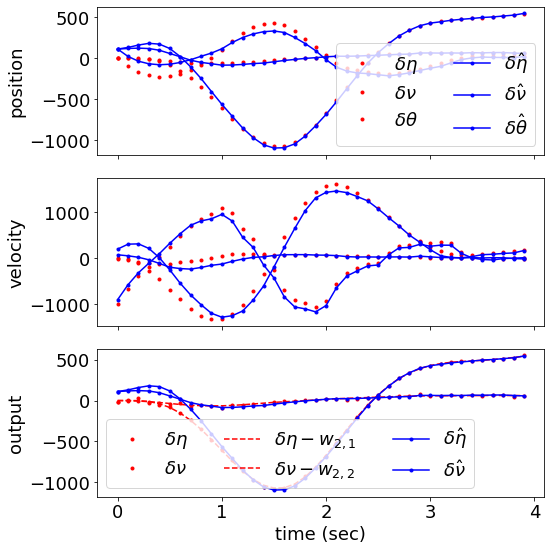

In [385]:
q = 1.
r = 1.

Q = q*np.eye(x0.size)
R = r*np.eye(u0.size)

P = [np.zeros((x0.size,x0.size))]
K = [np.zeros((u0.size,x0.size))]
for t in t_:
    P.append( (A - B @ K[-1]).T @ P[-1] @ (A - B @ K[-1]) + K[-1].T @ R @ K[-1] + Q )
    K.append( np.linalg.inv(B.T @ P[-1] @ B + R) @ B.T @ P[-1] @ A )
P = np.asarray(P)[::-1]
K = np.asarray(K)[::-1]

# high noise
s1 = 1e+1
s2 = 1e+1

V1 = s1*np.eye(x0.size//2)
V10 = np.vstack((0*V1,V1))
V2 = s2*np.eye(y0.size)

M = [np.zeros((x0.size,x0.size))]
L = [np.zeros((x0.size,y0.size))]
I = np.eye(x0.size)
for t in t_:
    W = A @ M[-1] @ A.T + V10 @ V10.T
    M.append( (I - L[-1] @ C) @ W @ (I - L[-1] @ C).T + L[-1] @ V2 @ V2.T @ L[-1].T )
    L.append( W @ C.T @ np.linalg.inv(V2 @ V2.T + C @ W @ C.T) )
M = np.asarray(M)
L = np.asarray(L)

du = []
dx = [np.random.randn(x0.size)] # dx in Python == \delta x in LaTeX
dy = []
dx_ = [np.zeros(x0.size) + 100*np.eye(x0.size)@np.ones(x0.size)]
for i,t in enumerate(t_):
    # LQG control input
    du.append( -K[i] @ dx_[-1] ) 
    # noisy process
    w1 = np.random.randn(x0.size//2)
    dx.append( A @ dx[-1] + B @ du[-1] + V10 @ w1 )
    # noisy measurements
    w2 = np.random.randn(y0.size)
    dy.append( C @ dx[-1] + D @ du[-1] + V2 @ w2 )
    # Kalman filter
    X = A @ dx_[-1] + B @ du[-1]
    dx_.append( X + L[i] @ (dy[-1] - C @ X) )
    
du = np.asarray(du)
dx = np.asarray(dx)
dy = np.asarray(dy)
dx_ = np.asarray(dx_)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,dx[1:,:3],'r.')
ax.plot(t_,dx_[1:,:3],'b.-')
ax.legend([r'$\delta\eta$',r'$\delta\nu$',r'$\delta\theta$',
           r'$\delta\hat\eta$',r'$\delta\hat\nu$',r'$\delta\hat\theta$'],ncol=2)
ax.set_xticklabels([])
ax.set_ylabel('position')

ax = plt.subplot(312)
ax.plot(t_,dx[1:,3:],'r.')
ax.plot(t_,dx_[1:,3:],'b.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,dy,'r.')
ax.plot(t_,dx[1:] @ C.T + du @ D.T,'r--')
ax.plot(t_,dx_[1:] @ C.T + du @ D.T,'b.-')
ax.legend([r'$\delta \eta$',r'$\delta \nu$',
           r'$\delta \eta - w_{2,1}$',r'$\delta \nu - w_{2,2}$',
           r'$\delta\hat \eta$',r'$\delta\hat \nu$'],ncol=3)
ax.set_xlabel('time (sec)')
ax.set_ylabel('output')

plt.tight_layout();

## subproblem (f) 

Now apply your LQG regulator to the discretized nonlinear system.  Run a simulation of the closed-loop system obtained from the feedback interconnection of the DT-NL system and your LQG regulator.  Provide plots comparing: the state $x$ and your estimate $\delta\hat{x}$; the noisy output $y$, noise-free output, and observer output $\delta\hat{y}$.

## solution

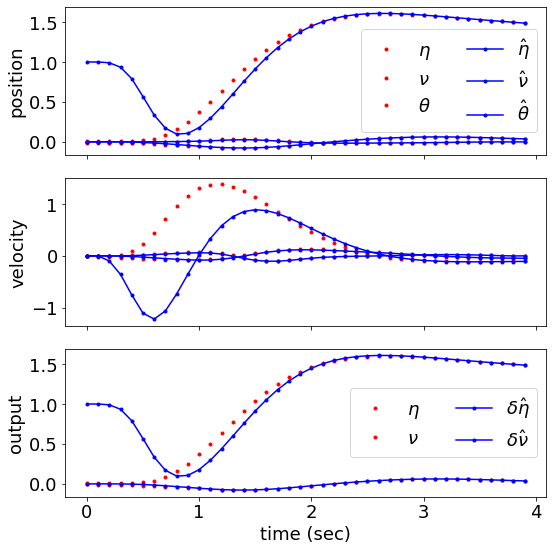

In [414]:
q = 1.
r = 1.

Q = q*np.eye(x0.size)
R = r*np.eye(u0.size)

P = [np.zeros((x0.size,x0.size))]
K = [np.zeros((u0.size,x0.size))]
for t in t_:
    P.append( (A - B @ K[-1]).T @ P[-1] @ (A - B @ K[-1]) + K[-1].T @ R @ K[-1] + Q )
    K.append( np.linalg.inv(B.T @ P[-1] @ B + R) @ B.T @ P[-1] @ A )
P = np.asarray(P)[::-1]
K = np.asarray(K)[::-1]

# low noise
s1 = 1e-4
s2 = 1e-4

V1 = s1*np.eye(x0.size//2)
V10 = np.vstack((0*V1,V1))
V2 = s2*np.eye(y0.size)

M = [np.zeros((x0.size,x0.size))]
L = [np.zeros((x0.size,y0.size))]
I = np.eye(x0.size)
for t in t_:
    W = A @ M[-1] @ A.T + V10 @ V10.T
    M.append( (I - L[-1] @ C) @ W @ (I - L[-1] @ C).T + L[-1] @ V2 @ V2.T @ L[-1].T )
    L.append( W @ C.T @ np.linalg.inv(V2 @ V2.T + C @ W @ C.T) )
M = np.asarray(M)
L = np.asarray(L)

du = []
x = [np.random.randn(x0.size)*1e-2] # dx in Python == \delta x in LaTeX
y = []
dx_ = [np.zeros(x0.size) + 0*np.eye(x0.size)@np.ones(x0.size)]
for i,t in enumerate(t_):
    # LQG control input
    du.append( -K[i] @ dx_[-1] ) 
    # noisy process
    w1 = np.random.randn(x0.size//2)
    x.append( x[-1] + dt * f(t,x[-1],u0+du[-1]) + V10 @ w1 )
    #x.append( x0 + A @ (x[-1] - x0) + B @ du[-1] + V10 @ w1 )
    # noisy measurements
    w2 = np.random.randn(y0.size)
    y.append( h(t,x[-1],u0+du[-1]) + V2 @ w2 )
    # Kalman filter
    X = A @ dx_[-1] + B @ du[-1]
    dx_.append( X + L[i] @ ( (y[-1] - y0) - C @ X) )
    
du = np.asarray(du)
x = np.asarray(x)
y = np.asarray(y)
dx_ = np.asarray(dx_)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x[1:,:3],'r.')
ax.plot(t_,(dx_+x0)[1:,:3],'b.-')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$',
           r'$\hat\eta$',r'$\hat\nu$',r'$\hat\theta$'],ncol=2)
ax.set_xticklabels([])
ax.set_ylabel('position')

ax = plt.subplot(312)
ax.plot(t_,x[1:,3:],'r.')
ax.plot(t_,(dx_+x0)[1:,3:],'b.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,y,'r.')
#ax.plot(t_,dx[1:] @ C.T + du @ D.T,'r--')
ax.plot(t_,y0 + dx_[1:] @ C.T + du @ D.T,'b.-')
ax.legend([r'$\eta$',r'$\nu$',
           #r'$\eta - w_{2,1}$',r'$\nu - w_{2,2}$',
           r'$\delta\hat \eta$',r'$\delta\hat \nu$'],ncol=2)
ax.set_xlabel('time (sec)')
ax.set_ylabel('output')

plt.tight_layout();

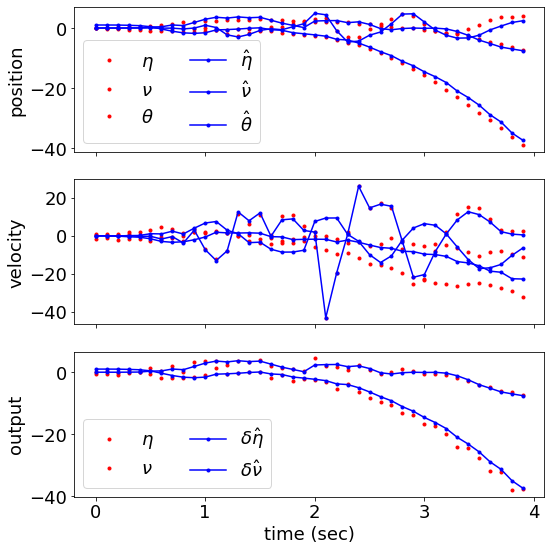

In [416]:
q = 1.
r = 1.

Q = q*np.eye(x0.size)
R = r*np.eye(u0.size)

P = [np.zeros((x0.size,x0.size))]
K = [np.zeros((u0.size,x0.size))]
for t in t_:
    P.append( (A - B @ K[-1]).T @ P[-1] @ (A - B @ K[-1]) + K[-1].T @ R @ K[-1] + Q )
    K.append( np.linalg.inv(B.T @ P[-1] @ B + R) @ B.T @ P[-1] @ A )
P = np.asarray(P)[::-1]
K = np.asarray(K)[::-1]

# high noise
s1 = 1e+0
s2 = 1e+0

V1 = s1*np.eye(x0.size//2)
V10 = np.vstack((0*V1,V1))
V2 = s2*np.eye(y0.size)

M = [np.zeros((x0.size,x0.size))]
L = [np.zeros((x0.size,y0.size))]
I = np.eye(x0.size)
for t in t_:
    W = A @ M[-1] @ A.T + V10 @ V10.T
    M.append( (I - L[-1] @ C) @ W @ (I - L[-1] @ C).T + L[-1] @ V2 @ V2.T @ L[-1].T )
    L.append( W @ C.T @ np.linalg.inv(V2 @ V2.T + C @ W @ C.T) )
M = np.asarray(M)
L = np.asarray(L)

du = []
x = [np.random.randn(x0.size)*1e-2] # dx in Python == \delta x in LaTeX
y = []
dx_ = [np.zeros(x0.size) + 0*np.eye(x0.size)@np.ones(x0.size)]
for i,t in enumerate(t_):
    # LQG control input
    du.append( -K[i] @ dx_[-1] ) 
    # noisy process
    w1 = np.random.randn(x0.size//2)
    x.append( x[-1] + dt * f(t,x[-1],u0+du[-1]) + V10 @ w1 )
    #x.append( x0 + A @ (x[-1] - x0) + B @ du[-1] + V10 @ w1 )
    # noisy measurements
    w2 = np.random.randn(y0.size)
    y.append( h(t,x[-1],u0+du[-1]) + V2 @ w2 )
    # Kalman filter
    X = A @ dx_[-1] + B @ du[-1]
    dx_.append( X + L[i] @ ( (y[-1] - y0) - C @ X) )
    
du = np.asarray(du)
x = np.asarray(x)
y = np.asarray(y)
dx_ = np.asarray(dx_)

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x[1:,:3],'r.')
ax.plot(t_,(dx_+x0)[1:,:3],'b.-')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$',
           r'$\hat\eta$',r'$\hat\nu$',r'$\hat\theta$'],ncol=2)
ax.set_xticklabels([])
ax.set_ylabel('position')

ax = plt.subplot(312)
ax.plot(t_,x[1:,3:],'r.')
ax.plot(t_,(dx_+x0)[1:,3:],'b.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,y,'r.')
#ax.plot(t_,dx[1:] @ C.T + du @ D.T,'r--')
ax.plot(t_,y0 + dx_[1:] @ C.T + du @ D.T,'b.-')
ax.legend([r'$\eta$',r'$\nu$',
           #r'$\eta - w_{2,1}$',r'$\nu - w_{2,2}$',
           r'$\delta\hat \eta$',r'$\delta\hat \nu$'],ncol=2)
ax.set_xlabel('time (sec)')
ax.set_ylabel('output')

plt.tight_layout();

# interlude

Reinterpreting the DT-LTI system above as a continuous-time process $P$ in the form expected for robust controller synthesis with inputs $w,\delta u$ and outputs $z,\delta y$ yields

$$
\delta \dot{x} = \bar{A}\, \delta x + B_1 w + B_2\, \delta u,\\
z = C_1\, \delta x + D_{11} w + D_{12}\, \delta u,\\
\delta y = C_2\, \delta x + D_{21} w + D_{22}\, \delta u
$$

where $\bar{A} = \frac{1}{\Delta}(A - I)$ and

$$
B_1 = \left[ \begin{array}{cc} 0 & 0 \\ \frac{1}{\Delta}V_1 & 0 \end{array} \right],\
B_2 = B,
$$

$$
C_1 = \left[ \begin{array}{c} \sqrt{\frac{1}{\Delta}Q} \\ 0 \end{array} \right],\
D_{11} = 0,\
D_{12} = \left[ \begin{array}{c} 0 \\ \sqrt{\frac{1}{\Delta}R}  \end{array} \right],
$$

$$
C_2 = \left[ \begin{array}{cc} C & 0 \end{array} \right],\
D_{21} = \left[ \begin{array}{cc} 0 & \frac{1}{\Delta}V_2 \end{array} \right],\
D_{22} = D.
$$

# part 2:  continuous-time, infinite-horizon

## subproblem (g) 

Use `control.h2syn`, i.e. the $H_2$ controller synthesis routine from the Control Systems Toolbox, to determine a dynamic regulator for $P$ that minimizes the $H_2$ norm of the closed-loop frequency-domain transformation from $w$ to $z$.  Discretize the resulting state-space regulator with the timestep $\Delta$ from part 1(a) and run a simulation of the closed-loop system obtained from the feedback interconnection of the DT-LTI system and your discretized $H_2$ regulator.  Provide plots comparing: the state $\delta x$ and your estimate $\delta\hat{x}$; the noise-free output $\delta y$, noisy output, and observer output $\delta\hat{y}$.

***Hint:*** use the following arguments to `h2syn`: `P = ctrl.ss(A,B,C,D)`, `nmeas = 2`, `ncont = 2` where

$$
B = \left[ \begin{array}{c} B_1 & B_2 \end{array} \right],\
C = \left[ \begin{array}{cc} C_1 \\ C_2 \end{array} \right],\
D = \left[ \begin{array}{cc} D_{11} & D_{12} \\ D_{21} & D_{22} \end{array} \right].
$$

## subproblem (h) 

Repeat the previous subproblem, but this time apply your compensator to the discrete-time *nonlinear* system from part 1(a).  By trial-and-error, determine how large $\Delta$ can be before the closed-loop system goes unstable -- denote that critical step size as $\bar{\Delta}$.  Provide the same plots from the previous subproblem for two values of $\Delta$:  one for which the closed-loop system is stable, and one for which the closed-loop system is (just barely) unstable.

## subproblem (i) 

Repeat (g), but use `control.hinfsyn`, i.e. the $H_\infty$ controller synthesis routine from the Control Systems Toolbox, to determine a dynamic regulator for $P$ that minimizes the $H_\infty$ norm of the closed-loop frequency-domain transformation from $w$ to $z$ (which happens to equal the induced norm of the closed-loop time-domain transformation from $w$ to $z$).

## subproblem (j)

Repeat (h), but use `control.hinfsyn`, and compare the $\bar{\Delta}$'s from (h) and (j).